In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
import geojson
import geopandas as gpd

import folium
from folium import Choropleth, Marker
from folium.features import DivIcon


Importing the Datasets

In [2]:
global_temp = pd.read_csv('./archive_1/GlobalTemperatures.csv')
country_temp_df = pd.read_csv('./archive_1/GlobalLandTemperaturesByCountry.csv')
emissions = pd.read_csv('edgar_data.csv')

In [3]:
emissions.columns = emissions.columns.str.replace('\xa0', '')  # Replace non-breaking spaces with normal spaces
emissions.columns = emissions.columns.str.strip() 

In [4]:
emissions.head()

,Country (unit),1990 (Mton CO2eq),2000 (Mton CO2eq),2005 (Mton CO2eq),2015 (Mton CO2eq),2020 (Mton CO2eq),2022 (Mton CO2eq),2023 (Mton CO2eq),2023% (% World Tot)
0,EU27,4877.28,4481.45,4553.56,3879.73,3388.28,3482.31,3221.79,6.08
1,GLOBAL TOTAL,32726.23,36175.15,41296.88,48808.77,49327.54,51968.47,52962.90,100.00
2,Afghanistan,12.56,13.92,15.57,27.41,26.65,28.61,29.46,0.06
3,Albania,11.49,7.18,7.98,8.74,7.97,7.81,7.67,0.01
4,Algeria,135.53,158.33,164.49,236.18,241.13,263.22,256.79,0.48


[]

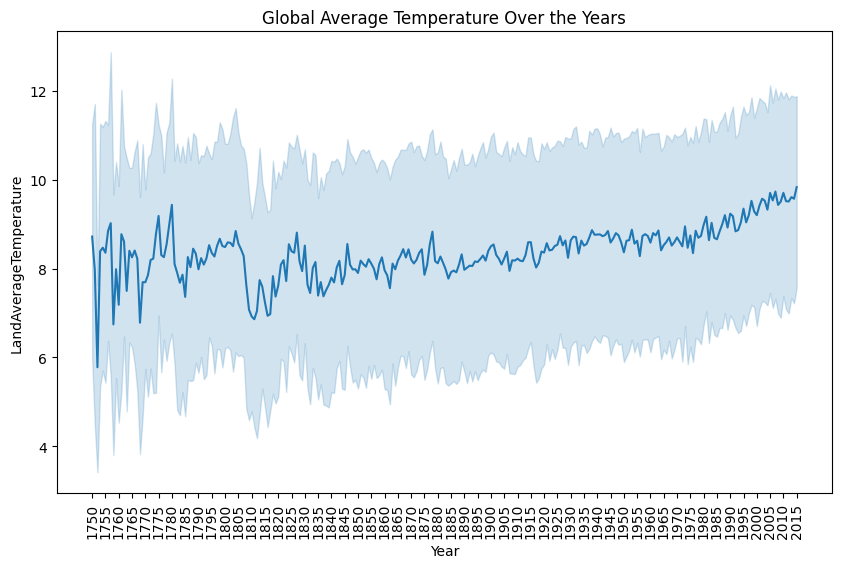

In [5]:
global_temp['Year']= global_temp['dt'].str[:4]
global_temp.dropna(inplace=True, how= 'all')
plt.figure(figsize=(10,6))
fig = sns.lineplot(data=global_temp, x = 'Year', y = 'LandAverageTemperature')
fig.set_xticks(fig.get_xticks()[::5], labels=fig.get_xticklabels()[::5], 
              rotation=90,
              fontsize=10)
plt.title('Global Average Temperature Over the Years')
plt.plot()

As shown in this graph the average land temperature is slowly rising over time which is harmful for the delicate balance of enviroment. It causes the melting of glaciers, destruction of wildlife habitat etc.

## Trainning Regression Model to Predict Future Temperatures

In [50]:
# Preparing the data
data = global_temp.copy()
data['Year'] = data['Year'].astype('int')
data = data[data['Year'] >= 1950].copy()
data = data[['Year','LandAverageTemperature']]
data = data.groupby("Year")["LandAverageTemperature"].mean().reset_index()
data['LandAverageTemperature']= data['LandAverageTemperature'].round(3)

In [ ]:
X = data['Year'].values.reshape(-1, 1)
y = data['LandAverageTemperature'].values

model = LinearRegression()
model.fit(X, y)

# Predicting temperature for the next 50 years
future_years = np.arange(data['Year'].max() + 1, data['Year'].max() + 51).reshape(-1, 1)
future_temperatures = model.predict(future_years)

future_predictions = pd.DataFrame({
    "Year": future_years.flatten(),
    "PredictedTemperature": future_temperatures
})

future_predictions.head()

,Year,PredictedTemperature
0,2016,9.597028
1,2017,9.615544
2,2018,9.634060
3,2019,9.652576
4,2020,9.671092


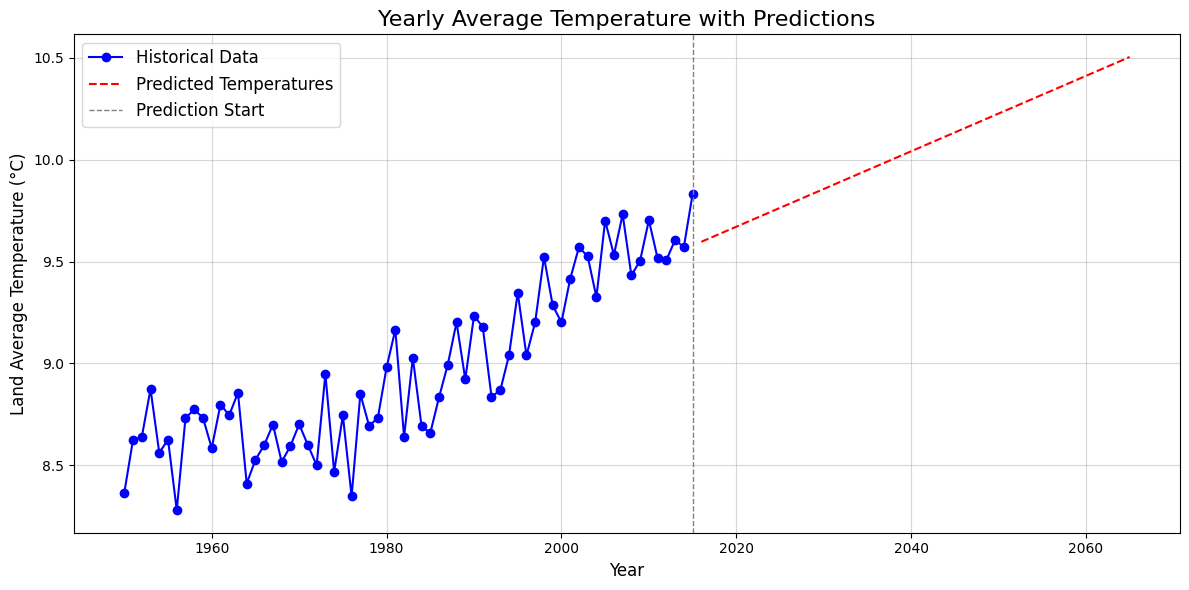

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['LandAverageTemperature'], label="Historical Data", marker='o', color='blue')
plt.plot(future_predictions['Year'], future_predictions['PredictedTemperature'], label="Predicted Temperatures", linestyle='--', color='red')

plt.title("Yearly Average Temperature with Predictions", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Land Average Temperature (°C)", fontsize=12)

plt.axvline(x=data['Year'].max(), color='gray', linestyle='--', linewidth=1, label="Prediction Start")
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

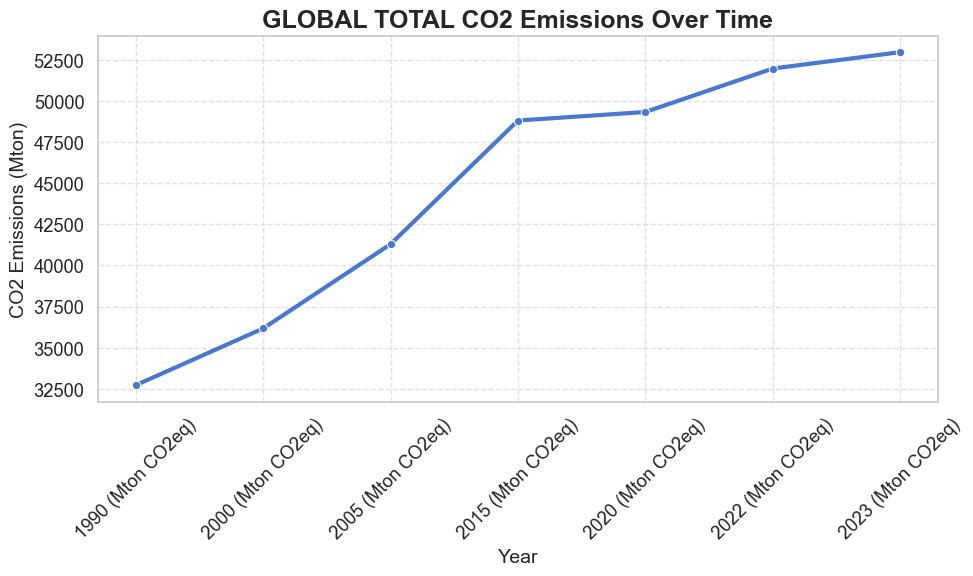

In [10]:
df = emissions.copy().drop(emissions.columns[-1], axis = 1)

global_total = df[df['Country (unit)'] == 'GLOBAL TOTAL'].drop(columns='Country (unit)')
global_total = global_total.T.reset_index()
global_total.columns = ['Year', 'CO2 Emissions (Mton)']

plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
sns.lineplot(x='Year', y='CO2 Emissions (Mton)', data=global_total , marker='o', linewidth=3, color='b')

plt.title('GLOBAL TOTAL CO2 Emissions Over Time', fontsize = 18, fontweight = 'bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Emissions (Mton)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As seen in this graph CO2 emissions from fossil fues and other sources is also rising by an alarming rate globally. CO2 emission is a major cause of Global Warming and climate change.

In [11]:
map_dict = {
    'United States': 'United States of America',
    'Congo': 'Democratic Republic of the Congo',
    "Côte D'Ivoire" : 'Ivory Coast',
    'Burma' : 'Myanmar',
    'Tanzania':'United Republic of Tanzania'
}

country_temp = country_temp_df.copy()
country_temp['Country'] = country_temp['Country'].str.replace(' (Europe)', '')
country_temp['Country'] = country_temp['Country'].replace(map_dict)

In [12]:
serbia = country_temp.loc[country_temp['Country'] == 'Serbia and Montenegro'].copy()
montenegro = serbia.copy()
serbia['Country'] = 'Republic of Serbia'
montenegro['Country'] = 'Montenegro'

country_temp = country_temp[country_temp['Country'] != 'Serbia and Montenegro']
country_temp = pd.concat([country_temp, serbia, montenegro], ignore_index=True)

In [13]:
#Measuring the Rise in Temperature In Various Countries
country_temp['Year'] = country_temp['dt'].str[:4]
# Old timeframe: [first year to consider, last year to consider]
old = [1950, 1954]

# New timeframe: [first year to consider, last year to consider]
# Bear in mind data only goes until 2013, and 2013 is incomplete
new = [2008, 2012]

cond_old = (country_temp['Year'] >= str(old[0])) & (country_temp['Year'] <= str(old[1]))
country_temp.loc[cond_old, 'Period'] = 'Old'

cond_new = (country_temp['Year'] >= str(new[0])) & (country_temp['Year'] <= str(new[1]))
country_temp.loc[cond_new, 'Period'] = 'New'

temp_diff = country_temp.pivot_table(index='Country', columns='Period', 
                                   values='AverageTemperature', aggfunc='mean')

temp_diff['Diff'] = temp_diff['New']-temp_diff['Old']

temp_diff = temp_diff.reset_index()

In [14]:

geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"

temp_map = folium.Map(location=[0, 0], zoom_start=2)

# Add the choropleth layer
Choropleth(
    geo_data=geojson_url,
    data=temp_diff,
    columns=['Country', 'Diff'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Temperature Difference (°C)',
    missing_kwds={
        "color": "white",
        "label": "No Data",  
        "fill_opacity": 1  
    }
).add_to(temp_map)

Marker(
    [-40, -40],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 10pt">Increase in temperature by country</div>',
        )
    ).add_to(temp_map)
Marker(
    [-50, -40],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt">1950 v/s 2015</div>',
        )
    ).add_to(temp_map)

    
# Save the map to an HTML file
temp_map.save("temperature_difference_map.html")
temp_map

Countries With Highest And Lowest Increase In Temperature

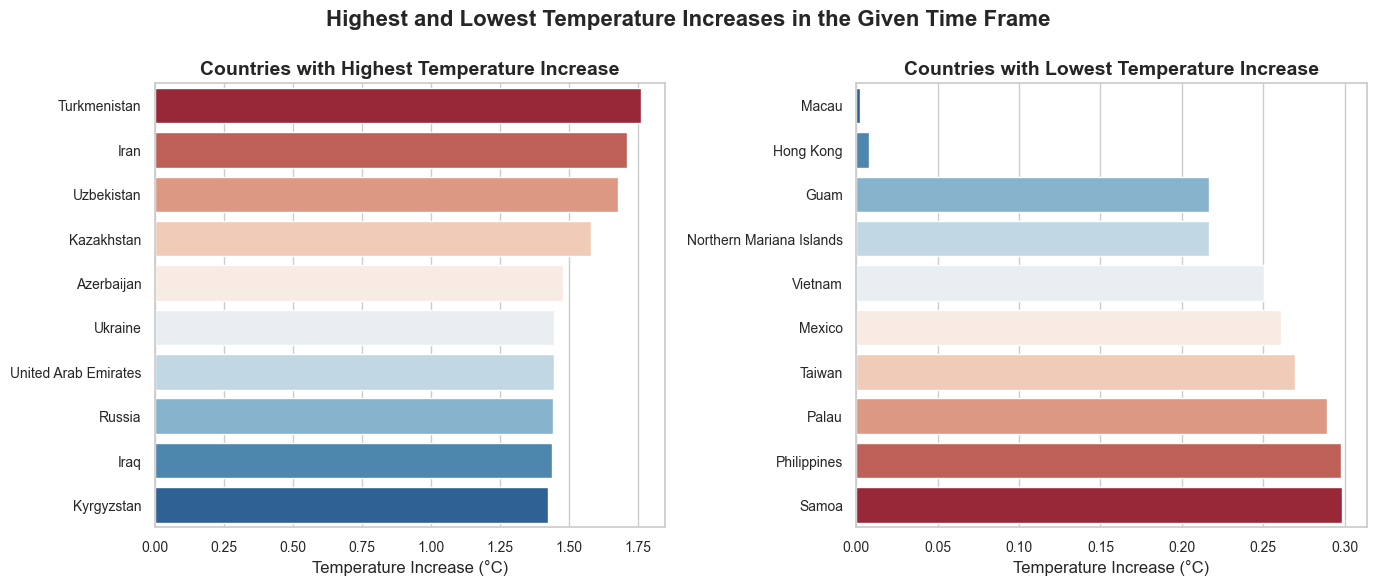

In [15]:
top_10 = temp_diff.sort_values('Diff', ascending=False)[:10]
bottom_10 = temp_diff.sort_values('Diff', ascending=True)[:10]

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)  # Adjust space between the plots

# Plot the highest temperature increases
sns.barplot(data=top_10, x='Diff', y='Country', ax=axes[0], palette='RdBu', hue='Country', legend=False)
axes[0].set_title('Countries with Highest Temperature Increase', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature Increase (°C)', fontsize=12)
axes[0].set_ylabel('')  # Remove y-label to avoid redundancy
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Plot the lowest temperature increases
sns.barplot(data=bottom_10, x='Diff', y='Country', ax=axes[1], palette='RdBu_r', hue='Country', legend=False)
axes[1].set_title('Countries with Lowest Temperature Increase', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Temperature Increase (°C)', fontsize=12)
axes[1].set_ylabel('')  # Remove y-label to avoid redundancy
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

# Set the overall figure title
plt.suptitle('Highest and Lowest Temperature Increases in the Given Time Frame', fontsize=16, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

Countries With Highest and Lowest CO2 Emissions

In [16]:
emission_tot = emissions.copy().drop(['2023% (% World Tot)'], axis= 1)
emission_tot.drop([0,1], inplace = True)
emission_tot.rename(columns={'Country (unit)': 'Country'}, inplace=True)
numeric_columns = emission_tot.select_dtypes(include=['number'])
emission_tot['Total'] = numeric_columns.sum(axis=1)

In [17]:
# Fixing name mismatch of Serbia and Montenegro
serbia = emission_tot.loc[emission_tot['Country'] == 'Serbia and Montenegro'].copy()
montenegro = serbia.copy()
serbia['Country'] = 'Republic of Serbia'
montenegro['Country'] = 'Montenegro'
serbia['Total'] = serbia['Total']/2
montenegro['Total'] = montenegro['Total']/2
emission_tot = emission_tot[emission_tot['Country'] != 'Serbia and Montenegro']
emission_tot = pd.concat([emission_tot, serbia, montenegro], ignore_index=True)

In [18]:
# Fixing Name Mismtch of Sudan and South Sudan
sudan = emission_tot.loc[emission_tot['Country'] == 'Sudan and South Sudan'].copy()
south = sudan.copy()
sudan['Country'] = 'Sudan'
south['Country'] = 'South Sudan'
sudan['Total'] = sudan['Total']/2
south['Total'] = south['Total']/2

emission_tot = emission_tot[emission_tot['Country'] != 'Sudan and South Sudan']
emission_tot = pd.concat([emission_tot, sudan, south], ignore_index=True)

In [19]:
print(np.where(emission_tot['Country'].unique() == 'Czechia'))

(array([50]),)


In [20]:
import json
import requests
geojson = requests.get(geojson_url).json()
countries = [feature['properties']['name'] for feature in geojson['features']]
print(countries.index('Democratic Republic of the Congo'))

33


In [21]:
map_dict = {
    'United States': 'United States of America',
    'France and Monaco': 'France',
    'Türkiye': 'Turkey',
    'Italy, San Marino and the Holy See': 'Italy',
    'Spain and Andorra': 'Spain',
    "Côte d’Ivoire" : 'Ivory Coast',
    'Myanmar/Burma' : 'Myanmar',
    'Tanzania':'United Republic of Tanzania',
    'Congo': 'Democratic Republic of the Congo',
    'Viet Nam':'Vietnam',
    'Switzerland and Liechtenstein': 'Switzerland',
    'Czechia':'Czech Republic'
}

emission_tot['Country'] = emission_tot['Country'].str.replace(' (Europe)', '')
emission_tot['Country'] = emission_tot['Country'].replace(map_dict)

In [22]:
em_map = folium.Map(location=[0, 0], zoom_start=2)

# Add the choropleth layer
Choropleth(
    geo_data=geojson_url,
    data=emission_tot,
    columns=['Country', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Temperature Difference (°C)',
    missing_kwds={
        "color": "white",
        "label": "No Data",  
        "fill_opacity": 1  
    }
).add_to(em_map)

Marker(
    [-40, -40],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 10pt">Total GHG Emissions</div>',
        )
    ).add_to(em_map)
Marker(
    [-50, -40],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt">1990-2023</div>',
        )
    ).add_to(em_map)

    
# Save the map to an HTML file
em_map.save("global_emissions_map.html")
em_map

In [23]:
emission_tot.head()

,Country,1990 (Mton CO2eq),2000 (Mton CO2eq),2005 (Mton CO2eq),2015 (Mton CO2eq),2020 (Mton CO2eq),2022 (Mton CO2eq),2023 (Mton CO2eq),Total
0,Afghanistan,12.56,13.92,15.57,27.41,26.65,28.61,29.46,154.18
1,Albania,11.49,7.18,7.98,8.74,7.97,7.81,7.67,58.84
2,Algeria,135.53,158.33,164.49,236.18,241.13,263.22,256.79,1455.67
3,Angola,31.94,67.02,66.45,81.78,61.68,67.21,67.70,443.78
4,Anguilla,0.01,0.02,0.02,0.03,0.03,0.03,0.03,0.17


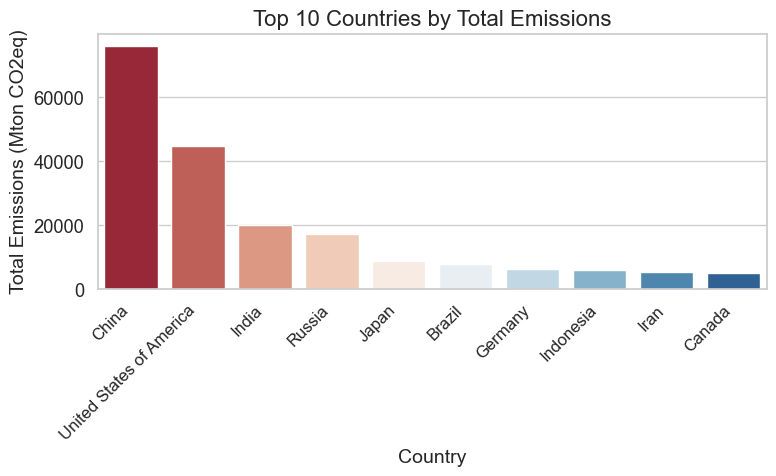

In [24]:
plt.figure(figsize=(8, 5))

sns.barplot(data=emission_tot.sort_values('Total', ascending=False)[:10], 
            x='Country', y='Total', palette='RdBu', hue = 'Country', legend= False)
plt.xticks(rotation=45, ha='right', fontsize=12)

plt.title('Top 10 Countries by Total Emissions', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Emissions (Mton CO2eq)', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()